### This notebook pulls the current state of the blockchain off the blockexplorer api and then simulates the future of the blockchain using a simple mean waiting time model with the true expected blocktime which is 150 second.

Totally stole jack's python function for block rewards

In [1]:
years = 5

COIN = 10**8
block_time = 150
blocks_per_ramp = 100
start_ramp_height = 5001
limit = 1083221000 * COIN
subsidy_interval = 1 << 5
max_reductions = 500
peak_reward = 500 * COIN
premine = 400000000 * COIN


def reward(n):
    assert n >= 0
    if n < 5001:
        return COIN
    elif n < 55001:
        r = 1 + ((n - ((n - start_ramp_height) % blocks_per_ramp) - start_ramp_height) / blocks_per_ramp)
        return r * COIN
    else:
        level = int((n - 55001) / subsidy_interval)
        reduction = int((-1 + int((8 * level) + 1) ** 0.5) / 2)
        while level >= ((reduction * reduction + reduction) >> 1):
            if ((reduction * reduction + reduction) >> 1) > level:
                reduction -= 1
            else:
                reduction += 1
        if reduction * COIN >= peak_reward:
            return 0
        return peak_reward - (reduction * COIN)

In [38]:
import numpy as np
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import json
import requests
block_count = int(requests.get("https://explorer.lbry.io/api/getblockcount").content)
def getblock(blockHash):
    return json.loads(requests.get("https://explorer.lbry.io/api/getblock?hash="+blockHash).content)

def getBlockTime(block):
    hashstr = requests.get("https://explorer.lbry.io/api/getblockhash?index="+str(block)).content
    return datetime.datetime.fromtimestamp(int(getblock(hashstr)['time']))

In [8]:
now = datetime.datetime.now()
block_data = {}

In [5]:
#randomized block time
def bt(prev_bt):
    avg_bt = float(block_time)
    seconds = np.random.exponential(scale=avg_bt)
    #print seconds
    return prev_bt + datetime.timedelta(seconds=seconds)

In [11]:
years = 5
i = block_count
block_data[block_count]={"height":block_count, "timestamp":now, "reward":reward(block_count)/COIN}
while block_data[i]["timestamp"] < now +datetime.timedelta(hours=365*24*years):
    i=i+1
    block_data[i] = {"height":i, "timestamp":bt(block_data[i-1]["timestamp"]), "reward":reward(i+1)/COIN}
    

In [13]:
df = pd.DataFrame(block_data).T

In [14]:
df.head()

,height,reward,timestamp
37233,37233,323,2016-08-30 18:30:30.474017
37234,37234,323,2016-08-30 18:30:37.855729
37235,37235,323,2016-08-30 18:31:32.454769
37236,37236,323,2016-08-30 18:34:51.969802
37237,37237,323,2016-08-30 18:38:41.597478


In [15]:
premine = 4*10**8
circulation = float(requests.get("https://explorer.lbry.io/ext/getmoneysupply").content)

df['liquid_supply'] = df.reward.cumsum()+circulation-premine
df['absolute_supply'] = df.liquid_supply+premine

In [16]:
df.head()

,height,reward,timestamp,liquid_supply,absolute_supply
37233,37233,323,2016-08-30 18:30:30.474017,5.21660e+06,4.05217e+08
37234,37234,323,2016-08-30 18:30:37.855729,5.21693e+06,4.05217e+08
37235,37235,323,2016-08-30 18:31:32.454769,5.21725e+06,4.05217e+08
37236,37236,323,2016-08-30 18:34:51.969802,5.21757e+06,4.05218e+08
37237,37237,323,2016-08-30 18:38:41.597478,5.2179e+06,4.05218e+08


In [27]:
tdf = df.set_index('timestamp')

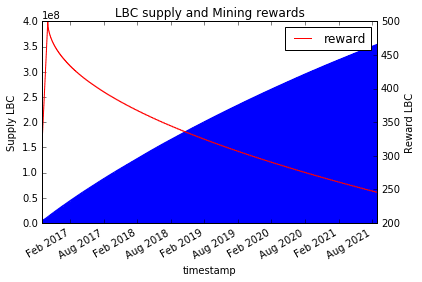

In [64]:
tdf.liquid_supply.plot(kind='area')
plt.ylabel('Supply LBC')
tdf.reward.plot(secondary_y=True, style='r', sharex=True)
plt.title('LBC supply and Mining rewards')
plt.legend()
plt.ylabel('Reward LBC')

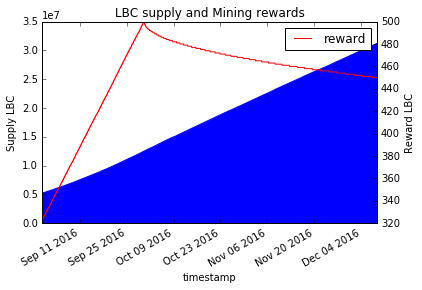

In [63]:
#100 days
days100 = now +datetime.timedelta(hours=24*100)
short_tdf=tdf[tdf.index <days100]
short_tdf.liquid_supply.plot(kind='area')
plt.ylabel('Supply LBC')
short_tdf.reward.plot(secondary_y=True, style='r', sharex=True)
plt.title('LBC supply and Mining rewards')
plt.legend()
plt.ylabel('Reward LBC')